In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

## Data Handling

In [84]:
# Import csv file from data folder
data = pd.read_csv('Price.csv')

# Explore data
print("Columns of dataset:", data.columns)
print("Price Areas: ", data['PriceArea'].unique())

# Filter all rows that do not equal DE for the column Country
data = data[data['PriceArea'] == 'DK2'].reset_index(drop=True) # adjust for DK2, not DE here!
data = data.drop(columns=['PriceDKK', 'PriceArea'])
data = data.rename(columns={'HourDK': 'Date', 'PriceEUR': 'Price', 'HourUTC': 'Hour'})
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')  # Convert to standard format
data['Hour'] = pd.to_timedelta(data['Hour']) + pd.Timedelta(hours=1) # Shift to UTC+1
data['Hour'] = data['Hour'].apply(lambda x: x - pd.Timedelta(days=1) if x >= pd.Timedelta(days=1) else x) # Handles the 24:00:00 case
data['Datetime'] = pd.to_datetime(data['Date']) + data['Hour']
data['Hour'] = data['Hour'].apply(lambda x: str(x).split(' ')[-1])
data['Hour'] = (pd.to_datetime(data['Hour'], format='%H:%M:%S')).dt.time
data.head(25)

Columns of dataset: Index(['HourUTC', 'HourDK', 'PriceArea', 'PriceDKK', 'PriceEUR'], dtype='object')
Price Areas:  ['DE' 'SE3' 'DK2' 'DK1' 'NO2' 'SE4' 'SYSTEM']


,Hour,Date,Price,Datetime
0,00:00:00,2021-01-01,50.869999,2021-01-01 00:00:00
1,01:00:00,2021-01-01,48.189999,2021-01-01 01:00:00
2,02:00:00,2021-01-01,44.680000,2021-01-01 02:00:00
3,03:00:00,2021-01-01,42.919998,2021-01-01 03:00:00
4,04:00:00,2021-01-01,40.389999,2021-01-01 04:00:00
5,05:00:00,2021-01-01,40.200001,2021-01-01 05:00:00
6,06:00:00,2021-01-01,39.630001,2021-01-01 06:00:00
7,07:00:00,2021-01-01,40.090000,2021-01-01 07:00:00
8,08:00:00,2021-01-01,41.270000,2021-01-01 08:00:00
9,09:00:00,2021-01-01,44.880001,2021-01-01 09:00:00


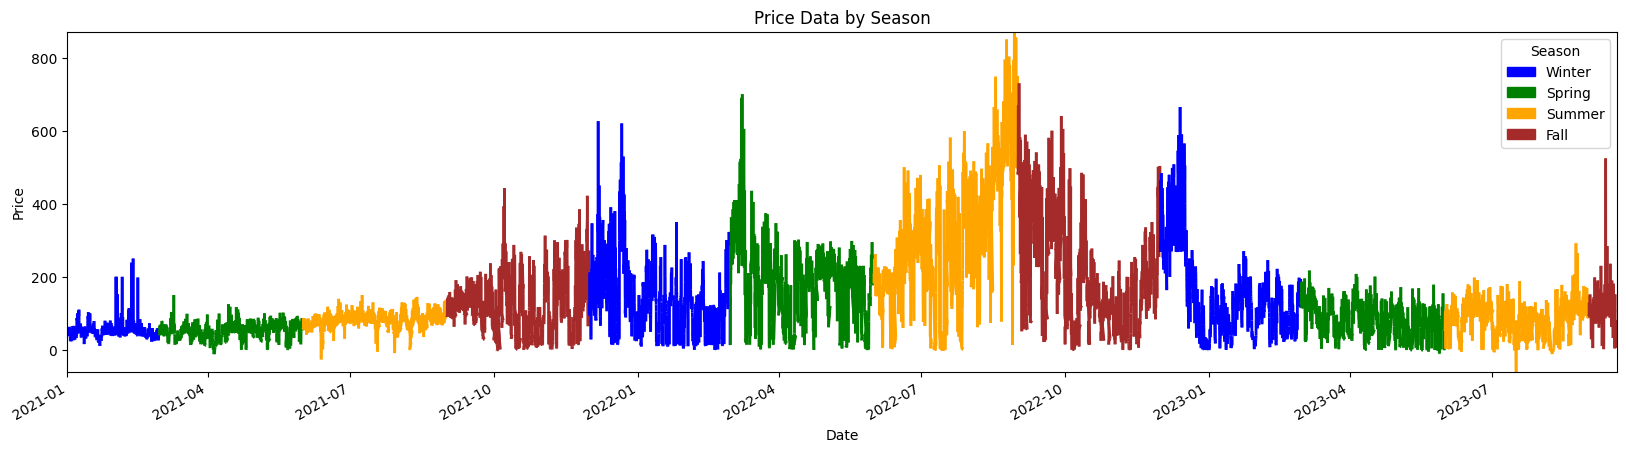

In [141]:
# Define seasons
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# Add a season column
data['Season'] = data['Datetime'].apply(get_season)

# Map seasons to colors
season_colors = {'Winter': 'blue', 'Spring': 'green', 'Summer': 'orange', 'Fall': 'brown'}
data['Color'] = data['Season'].map(season_colors)

# Prepare data for LineCollection
dates = data['Datetime'].values
prices = data['Price'].values
points = np.array([mdates.date2num(dates), prices]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
colors = data['Color'].values[:-1]  # Create color array for segments

# Create LineCollection
lc = LineCollection(segments, colors=colors, linewidths=2)

# Plot
fig, ax = plt.subplots(figsize=(20, 5))
ax.add_collection(lc)
ax.set_xlim(dates.min(), dates.max())
ax.set_ylim(prices.min(), prices.max())
ax.set_title('Price Data by Season')
ax.set_xlabel('Date')
ax.set_ylabel('Price')

# Format x-axis with proper dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()

# Create custom legend
legend_handles = [mpatches.Patch(color=color, label=season) for season, color in season_colors.items()]
ax.legend(handles=legend_handles, title='Season')
plt.show()

# Drop auxiliary columns
data = data.drop(columns=['Season', 'Color'])

Total number of elements in the dataframe for region 'DK2': 23783
Number of elements in each category (equal-sized bins):
Category
Category 1    5946
Category 2    5946
Category 3    5945
Category 4    5946
Name: count, dtype: int64


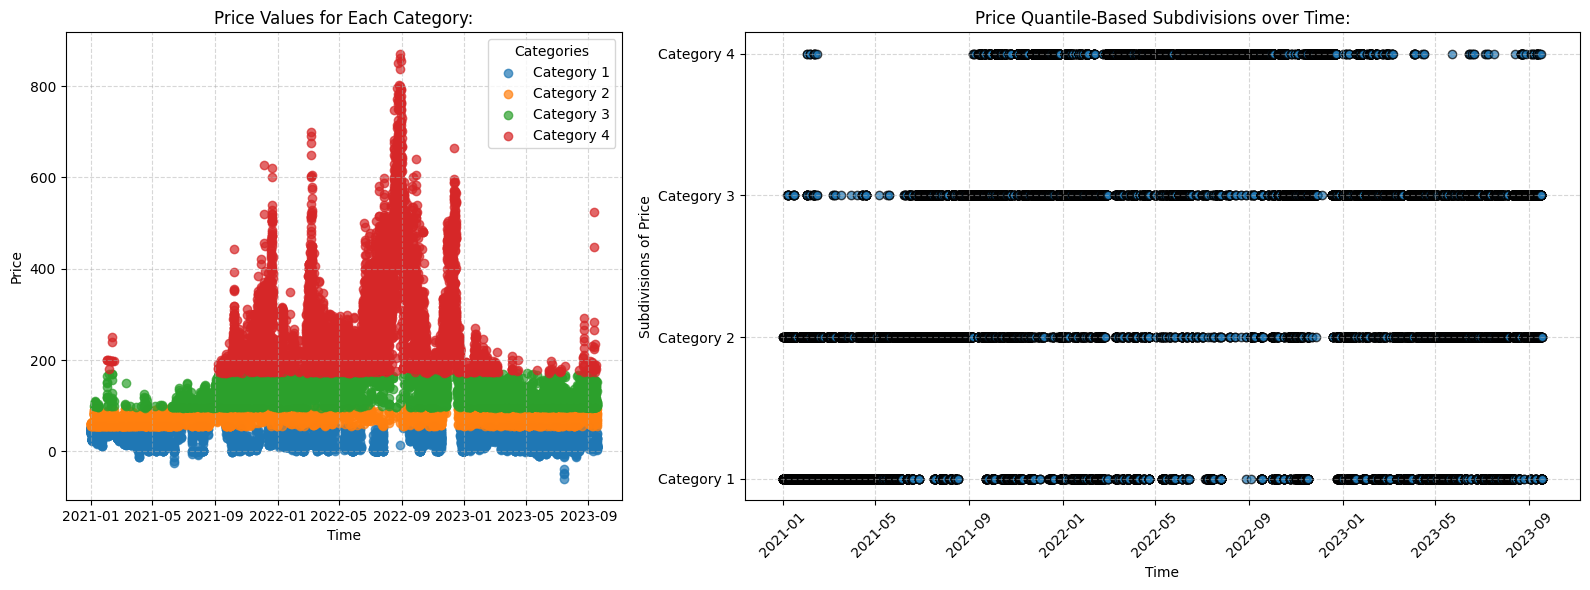

In [142]:
def plot_qcut(df, column, subdivisions, time_column):
    """
    Create a subplot with the quantile-based subdivisions scatter plot on the right and 
    line plots of the prices for each category on the left.
    
    Parameters:
        df (pd.DataFrame): The input dataframe containing the data.
        region (str): The region to filter the data by.
        column (str): The column to analyze and plot.
        subdivisions (int): The number of quantile-based subdivisions for the column.
        time_column (str): The time column to use for the x-axis.
    
    Returns:
        None: Displays a subplot with the quantile-based subdivisions and category line plots.
    """
    
    # Print the total number of elements in the dataframe for the specified region
    total_elements = len(df)
    print(f"Total number of elements in the dataframe for region 'DK2': {total_elements}")

    # Discretize the column into quantile-based subdivisions
    labels = [f"Category {i+1}" for i in range(subdivisions)]
    df['Category'] = pd.qcut(df[column], q=subdivisions, labels=labels)
    
    # Print the number of elements in each category
    category_counts = df['Category'].value_counts().sort_index()
    print("Number of elements in each category (equal-sized bins):")
    print(category_counts)
    
    # Ensure time column is in datetime format
    df[time_column] = pd.to_datetime(df[time_column])
    
    # Set up subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 3]})
    
    # Plot line plots of prices for each category (left plot)
    for category in labels:
        category_df = df[df['Category'] == category]
        axes[0].scatter(category_df[time_column], category_df[column], label=category, alpha=0.7)
    axes[0].set_title(f"{column} Values for Each Category:")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel(column)
    axes[0].legend(title="Categories")
    axes[0].grid(True, linestyle='--', alpha=0.5)
    
    # Plot scatter plot of quantile-based subdivisions (right plot)
    axes[1].scatter(df[time_column], df['Category'], alpha=0.7, edgecolor='k')
    axes[1].set_title(f"{column} Quantile-Based Subdivisions over Time:")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel(f"Subdivisions of {column}")
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_qcut(data, column='Price', subdivisions=4, time_column='Date')
   

In [143]:
def dynamic_categorization(df, column, time_column, window_size):
    # Ensure the time column is sorted and in datetime format
    df[time_column] = pd.to_datetime(df[time_column])
    df = df.sort_values(by=[time_column, 'Hour'])

    # Compute rolling statistics (mean+std)
    df['RollingMean'] = df[column].rolling(window=window_size, min_periods=1).mean()
    df['RollingStd'] = df[column].rolling(window=window_size, min_periods=1).std() # 2 values needed for std -> first row will always be NaN!

    # Fill NaN std values with a small constant (e.g., 1) to avoid division errors
    df['RollingStd'] = df['RollingStd'].fillna(1)

    # Compute Z-scores
    df['ZScore'] = (df[column] - df['RollingMean']) / df['RollingStd']

    # Categorize based on Z-scores
    bins = [-float('inf'), -1.5, -0.5, 0.5, 1.5, float('inf')]
    labels = ['Very Low', 'Low', 'Normal', 'High', 'Very High']
    df['Category'] = pd.cut(df['ZScore'], bins=bins, labels=labels)

    return df

# Apply function to categorize
categorized_data = dynamic_categorization(data, column='Price', time_column='Date', window_size=1000)
categorized_data.head(10)

,Hour,Date,Price,Datetime,Category,RollingMean,RollingStd,ZScore
0,00:00:00,2021-01-01,50.869999,2021-01-01 00:00:00,Normal,50.869999,1.000000,0.000000
1,01:00:00,2021-01-01,48.189999,2021-01-01 01:00:00,Low,49.529999,1.895046,-0.707107
2,02:00:00,2021-01-01,44.680000,2021-01-01 02:00:00,Low,47.913333,3.104260,-1.041579
3,03:00:00,2021-01-01,42.919998,2021-01-01 03:00:00,Low,46.664999,3.557757,-1.052630
4,04:00:00,2021-01-01,40.389999,2021-01-01 04:00:00,Low,45.409999,4.167535,-1.204549
5,05:00:00,2021-01-01,40.200001,2021-01-01 05:00:00,Low,44.541666,4.291701,-1.011642
6,06:00:00,2021-01-01,39.630001,2021-01-01 06:00:00,Low,43.840000,4.335350,-0.971086
7,07:00:00,2021-01-01,40.090000,2021-01-01 07:00:00,Low,43.371250,4.227060,-0.776249
8,08:00:00,2021-01-01,41.270000,2021-01-01 08:00:00,Normal,43.137777,4.015609,-0.465129
9,09:00:00,2021-01-01,44.880001,2021-01-01 09:00:00,Normal,43.312000,3.825829,0.409846


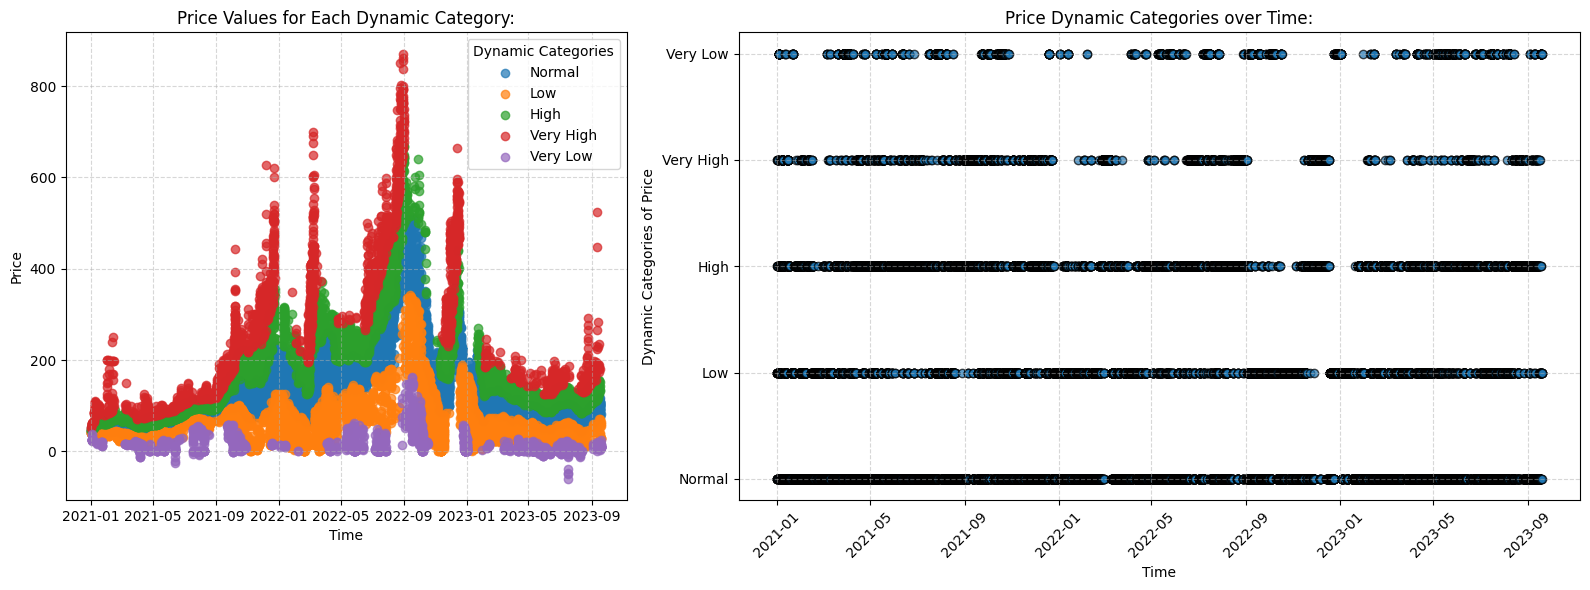

In [144]:
def plot_dynamic_categorization(df, column, time_column):
    """
    Create a subplot with the dynamically categorized data scatter plot on the right
    and line plots of the values for each dynamic category on the left.

    Parameters:
        df (pd.DataFrame): The input dataframe containing the categorized data.
        column (str): The column to analyze and plot.
        time_column (str): The time column to use for the x-axis.
    
    Returns:
        None: Displays a subplot with the categorized data and category-based line plots.
    """
    # Ensure time column is in datetime format and sorted
    df[time_column] = pd.to_datetime(df[time_column])
    df = df.sort_values(by=time_column)

    # Get unique categories for dynamic labeling
    unique_categories = df['Category'].dropna().unique()

    # Set up subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 3]})

    # Plot scatter plots of values for each dynamic category (left plot)
    for category in unique_categories:
        category_df = df[df['Category'] == category]
        axes[0].scatter(category_df[time_column], category_df[column], label=category, alpha=0.7)
    axes[0].set_title(f"{column} Values for Each Dynamic Category:")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel(column)
    axes[0].legend(title="Dynamic Categories")
    axes[0].grid(True, linestyle='--', alpha=0.5)

    # Plot scatter plot of dynamic categories over time (right plot)
    axes[1].scatter(df[time_column], df['Category'], alpha=0.7, edgecolor='k')
    axes[1].set_title(f"{column} Dynamic Categories over Time:")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel(f"Dynamic Categories of {column}")
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# Apply function to plot
plot_dynamic_categorization(categorized_data, column='Price', time_column='Datetime')

In [145]:
def categorize_prices(df, price_column="Price"):
    """
    Categorize prices in a DataFrame column into four categories:
    - Negative Prices
    - Low Prices (bottom 33% of non-negative prices)
    - Medium Prices (middle 33% of non-negative prices)
    - High Prices (top 33% of non-negative prices)

    Args:
    - df: Input DataFrame with a column of prices.
    - price_column: Name of the column containing price data (default is "PriceEUR").

    Returns:
    - DataFrame with an additional "Category" column for the price categories.
    """
    # Ensure the column exists
    if price_column not in df.columns:
        raise ValueError(f"Column '{price_column}' not found in the DataFrame.")

    # Extract the price column
    prices = df[price_column]

    # Separate negative prices
    negative_mask = prices < 0
    negative_prices = prices[negative_mask]

    # Non-negative prices
    non_negative_prices = prices[~negative_mask]

    # Calculate quantiles for non-negative prices
    low_threshold = non_negative_prices.quantile(0.33)
    medium_threshold = non_negative_prices.quantile(0.67)

    # Categorize prices
    categories = []
    for price in prices:
        if price < 0:
            categories.append("Negative")
        elif price <= low_threshold:
            categories.append("Low")
        elif price <= medium_threshold:
            categories.append("Medium")
        else:
            categories.append("High")

    # Add the categories as a new column to the DataFrame
    df["Category"] = categories

    return df   

In [146]:
# Categorize the prices
Categorized_PriceData = categorize_prices(data,price_column="Price")

In [154]:
def calculate_transition_matrix(df, category_column="Category"):
    """
    Calculate the transition probability matrix for categories.

    Args:
    - df: DataFrame with a sequential column of categories.
    - category_column: Name of the column containing the categories.

    Returns:
    - 4x4 transition probability matrix as a DataFrame.
    """
    # Ensure the column exists
    if category_column not in df.columns:
        raise ValueError(f"Column '{category_column}' not found in the DataFrame.")

    # Extract categories from input df

    categories = df[category_column].unique()
    transitions = df[category_column].values

    # Initialize a 4x4 matrix for counts
    transition_counts = pd.DataFrame(
        np.zeros((len(categories), len(categories))),
        index=categories,
        columns=categories,
    )

    # Count transitions
    for i in range(len(transitions) - 1):
        current_category = transitions[i]
        next_category = transitions[i + 1]
        if current_category in categories and next_category in categories:
            transition_counts.loc[current_category, next_category] += 1

    # Normalize rows to get probabilities
    transition_matrix = transition_counts.div(transition_counts.sum(axis=1), axis=0).fillna(0)

    return transition_matrix


In [155]:
def calculate_transition_matrix2(df, column, subdivisions):
    """
    Calculate a transition matrix for a given column using quantile-based subdivisions.
    
    Parameters:
        df (pd.DataFrame): The input dataframe containing the data.
        column (str): The name of the column to analyze.
        subdivisions (int): The number of quantile-based subdivisions for the data.
    
    Returns:
        pd.DataFrame: A transition matrix showing probabilities of moving between categories.
    """
    # Ensure the specified column exists in the dataframe
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in the DataFrame.")
    
    # Discretize the column into quantile-based categories using pd.qcut
    labels = [f"Category {i+1}" for i in range(subdivisions)]
    df['Category'] = pd.qcut(df[column], q=subdivisions, labels=labels)
    
    # Calculate transitions between categories
    transitions = pd.crosstab(
        df['Category'][:-1].values,  # Current category
        df['Category'][1:].values,  # Next category
        normalize='index'           # Normalize row-wise
    )
    
    return transitions


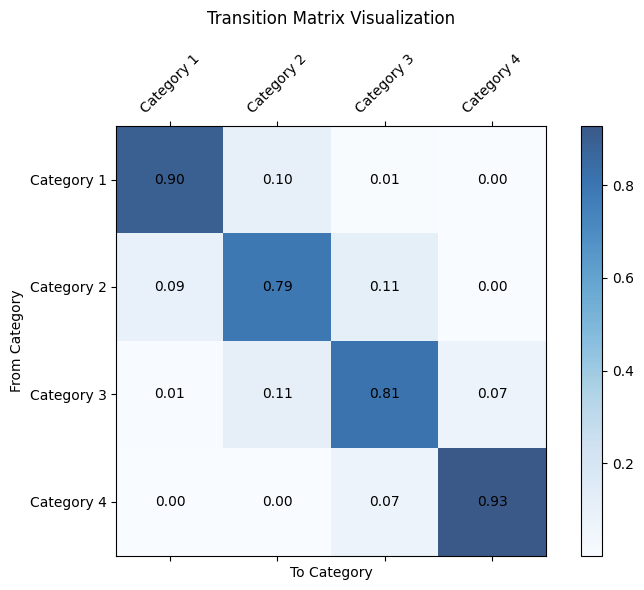

In [156]:
# Calculate transition probabilities
transition_matrix = calculate_transition_matrix(Categorized_PriceData).to_dict()
transition_matrix_df = pd.DataFrame(transition_matrix).T

# Plotting the transition matrix
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(transition_matrix_df.values, cmap='Blues', alpha=0.8)

# Add text annotations
for (i, j), val in np.ndenumerate(transition_matrix_df.values):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

# Formatting the plot
plt.xticks(range(len(transition_matrix_df.columns)), transition_matrix_df.columns, rotation=45)
plt.yticks(range(len(transition_matrix_df.index)), transition_matrix_df.index)
plt.title("Transition Matrix Visualization", pad=20)
plt.xlabel("To Category")
plt.ylabel("From Category")
plt.colorbar(cax)
plt.tight_layout()
plt.show()



Transition Matrix:
{'Category 1': {'Category 1': 0.8973927670311186, 'Category 2': 0.09569458459468551, 'Category 3': 0.005719091673675358, 'Category 4': 0.0011772620248906827}, 'Category 2': {'Category 1': 0.09217830109335576, 'Category 2': 0.7934746047763203, 'Category 3': 0.11286795626576955, 'Category 4': 0.0015136226034308778}, 'Category 3': {'Category 1': 0.008915054667788058, 'Category 2': 0.10746720484359233, 'Category 3': 0.8141295206055509, 'Category 4': 0.06945845946855028}, 'Category 4': {'Category 1': 0.0015138772077375945, 'Category 2': 0.003363605785401951, 'Category 3': 0.0672834314550042, 'Category 4': 0.9278506559031282}}


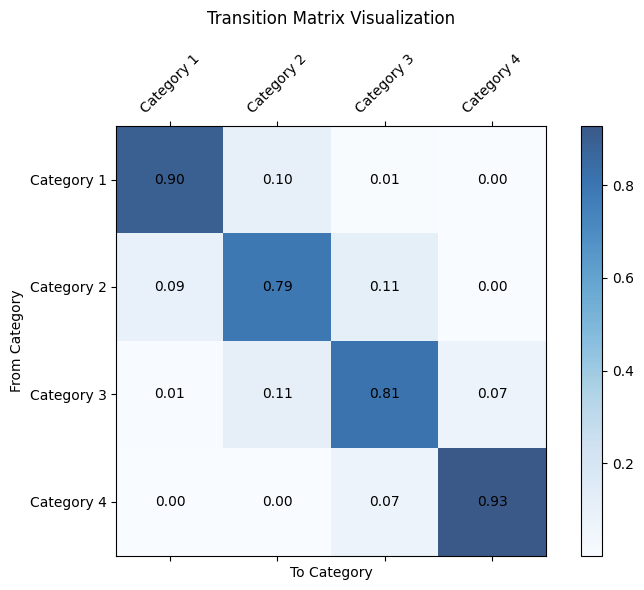

In [157]:
# Example usage
subdivisions = 4
column = 'Price'
transition_matrix2 = calculate_transition_matrix2(Categorized_PriceData, column, subdivisions).to_dict()
transition_matrix_df = pd.DataFrame(transition_matrix2).T

# Display the transition matrix
print("Transition Matrix:")
print(transition_matrix2)

# Plotting the transition matrix
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(transition_matrix_df.values, cmap='Blues', alpha=0.8)

# Add text annotations
for (i, j), val in np.ndenumerate(transition_matrix_df.values):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

# Formatting the plot
plt.xticks(range(len(transition_matrix_df.columns)), transition_matrix_df.columns, rotation=45)
plt.yticks(range(len(transition_matrix_df.index)), transition_matrix_df.index)
plt.title("Transition Matrix Visualization", pad=20)
plt.xlabel("To Category")
plt.ylabel("From Category")
plt.colorbar(cax)
plt.tight_layout()
plt.show()


In [95]:
class BatteryOptimization:
    def __init__(self, states, actions, price_df, transition_prob, gamma=0.9, epsilon=0.01):
        """
        Initialize the Battery Optimization problem.
        
        Args:
        - states: List of all possible states (SOC, PriceCategory).
        - actions: List of possible actions (e.g., ["Charge", "Discharge", "Nothing"]).
        - price_df: DataFrame with columns ['PriceValue', 'PriceCategory'].
        - transition_prob: Dictionary with transition probabilities between price categories.
        - gamma: Discount factor (default 0.9).
        - epsilon: Convergence threshold for value iteration (default 0.01).
        """
        self.states = states
        self.actions = actions
        self.price_df = price_df.set_index("Category")  # Easier access by category
        self.transition_prob = transition_prob
        self.gamma = gamma
        self.epsilon = epsilon
        self.value_function = np.zeros(len(states))  # Initialize V(s) = 0 for all states
        self.policy = ["Nothing"] * len(states)  # Initialize policy

    def is_valid_action(self, soc, action):
        """Checks if an action is valid for a given SOC."""
        if action == "Discharge" and soc == 0:
            return False  # Cannot discharge at SOC = 0
        if action == "Charge" and soc == 500:
            return False  # Cannot charge at SOC = 500
        return True

    def get_next_state(self, soc, action):
        """Calculates the next SOC based on the action."""
        if action == "Charge" and soc < 500:
            return soc + 100
        elif action == "Discharge" and soc > 0:
            return soc - 100
        return soc  # "Nothing" or out-of-bound action

    def reward(self, action, price_category):
        price_value = self.price_df.loc[price_category, "Price"]
        if isinstance(price_value, pd.Series):
            price_value = price_value.iloc[0]  # Use the first value
        if action == "Charge":
            return -100 * price_value
        elif action == "Discharge":
            return 100 * price_value
        return 0

    def value_iteration(self):
        while True:
            delta = 0
            new_value_function = np.zeros(len(self.states))

            for s, (soc, price_category) in enumerate(self.states):
                action_values = []

                for action in self.actions:
                    if not self.is_valid_action(soc, action):
                        continue  # Skip invalid actions

                    # Calculate next SOC
                    next_soc = self.get_next_state(soc, action)
                    expected_value = 0

                    # Compute expected value for transitioning to next states
                    for next_price_category, prob in self.transition_prob[price_category].items():
                        next_state = (next_soc, next_price_category)
                        if next_state in self.states:
                            next_state_index = self.states.index(next_state)
                            reward = self.reward(action, price_category)
                            expected_value += prob * (reward + self.gamma * self.value_function[next_state_index])

                    action_values.append(expected_value)

                # Update the value for this state
                if action_values:
                    new_value_function[s] = max(action_values)
                else:
                    new_value_function[s] = self.value_function[s]

                delta = max(delta, abs(new_value_function[s] - self.value_function[s]))

            self.value_function = new_value_function
            if delta < self.epsilon:
                break

    def extract_policy(self):
        for s, (soc, price_category) in enumerate(self.states):
            action_values = []

            for action in self.actions:
                if not self.is_valid_action(soc, action):
                    continue  # Skip invalid actions

                # Calculate next SOC
                next_soc = self.get_next_state(soc, action)
                expected_value = 0

                # Compute expected value for transitioning to next states
                for next_price_category, prob in self.transition_prob[price_category].items():
                    next_state = (next_soc, next_price_category)
                    if next_state in self.states:
                        next_state_index = self.states.index(next_state)
                        reward = self.reward(action, price_category)
                        expected_value += prob * (reward + self.gamma * self.value_function[next_state_index])

                action_values.append((expected_value, action))

            # Select action with the highest value
            if action_values:
                _, best_action = max(action_values)
                self.policy[s] = best_action
            else:
                self.policy[s] = "Nothing"  # Default if no valid actions

    def solve(self):
        """Runs value iteration and extracts the optimal policy."""
        self.value_iteration()
        self.extract_policy()




In [205]:
class BatteryValueIteration:
    def __init__(self, soc_levels, actions, price_series, price_categories, transition_matrix, gamma=0.9, epsilon=0.01):
        """
        Initialize the Battery Value Iteration problem.
        
        Args:
        - soc_levels: List of SOC levels (e.g., [0, 100, 200, ..., 500]).
        - actions: List of actions (e.g., ["Charge", "Discharge", "Nothing"]).
        - price_series: DataFrame with columns ['Hour', 'Category', 'Price'].
        - price_categories: List of unique price categories (e.g., ["Negative", "Low", "Medium", "High"]).
        - transition_matrix: Transition probability matrix (dict of dicts).
        - gamma: Discount factor (default 0.9).
        - epsilon: Convergence threshold for value iteration (default 0.01).
        """
        self.soc_levels = soc_levels
        self.actions = actions
        self.price_series = price_series
        self.price_categories = price_categories
        self.transition_matrix = transition_matrix
        self.gamma = gamma
        self.epsilon = epsilon
        
        # Define all possible states as (SOC, PriceCategory)
        self.states = [(soc, category) for soc in soc_levels for category in price_categories]
        
        # Initialize value function and policy
        self.value_function = {state: 0 for state in self.states}
        self.policy = {state: "Nothing" for state in self.states}

    def is_valid_action(self, soc, action):
        """Check if the action is valid given the SOC."""
        valid = not (
            (action == "Discharge" and soc == 0) or
            (action == "Charge" and soc == max(self.soc_levels))
        )
        print(f"Action: {action}, SOC: {soc}, Valid: {valid}")  # Debugging action validity
        return valid

    def get_next_soc(self, soc, action):
        """Determine the next SOC based on the action."""
        if action == "Charge":
            return min(soc + 100, max(self.soc_levels))
        elif action == "Discharge":
            return max(soc - 100, 0)
        return soc

    def reward(self, action, price):
        """Calculate the reward for a given action and price."""
        if action == "Charge":
            return -100 * price  # Cost of charging
        elif action == "Discharge":
            return 100 * price  # Revenue from discharging
        return 0  # No cost/reward for doing nothing

    def value_iteration(self):
        """Perform the value iteration algorithm."""
        while True:
            delta = 0  # Track convergence
            new_value_function = self.value_function.copy()

            for state in self.states:
                soc, price_category = state
                action_values = []

                for action in self.actions:
                    # Enforce validity check
                    if not self.is_valid_action(soc, action):
                        continue

                    next_soc = self.get_next_soc(soc, action)
                    expected_value = 0

                    for next_category, prob in self.transition_matrix[price_category].items():
                        next_state = (next_soc, next_category)
                        if next_state in self.states:
                            reward = self.reward(
                                action,
                                self.price_series[self.price_series["Category"] == next_category]["Price"].mean(),
                            )
                            expected_value += prob * (reward + self.gamma * self.value_function[next_state])

                    action_values.append(expected_value)

                # Debugging: Print state and valid actions
                print(f"State: {state}, Valid Actions: {action_values}")

                # Update the value function and policy only if valid actions exist
                if action_values:
                    best_action_index = np.argmax(action_values)
                    new_value_function[state] = action_values[best_action_index]
                    self.policy[state] = self.actions[best_action_index]
                else:
                    # No valid actions; set default values
                    new_value_function[state] = self.value_function[state]
                    self.policy[state] = "Nothing"

                delta = max(delta, abs(new_value_function[state] - self.value_function[state]))

            self.value_function = new_value_function
            if delta < self.epsilon:
                break

    def get_policy(self):
        """Return the computed policy."""
        return self.policy

    def get_value_function(self):
        """Return the computed value function."""
        return self.value_function


In [97]:
class BatteryValueIteration2:
    def __init__(self, soc_levels, actions, price_series, price_categories, transition_matrix, gamma=0.9, epsilon=0.01):
        """
        Initialize the Battery Value Iteration problem.
        
        Args:
        - soc_levels: List of SOC levels (e.g., [0, 100, 200, ..., 500]).
        - actions: List of actions (e.g., ["Charge", "Discharge", "Nothing"]).
        - price_series: DataFrame with columns ['Hour', 'Category', 'Price'].
        - price_categories: List of unique price categories (e.g., ["Negative", "Low", "Medium", "High"]).
        - transition_matrix: Transition probability matrix (dict of dicts).
        - gamma: Discount factor (default 0.9).
        - epsilon: Convergence threshold for value iteration (default 0.01).
        """
        self.soc_levels = soc_levels
        self.actions = actions
        self.price_series = price_series
        self.price_categories = price_categories
        self.transition_matrix = transition_matrix
        self.gamma = gamma
        self.epsilon = epsilon
        
        # Define all possible states as (SOC, PriceCategory)
        self.states = [(soc, category) for soc in soc_levels for category in price_categories]
        
        # Initialize value function and policy
        self.value_function = {state: 0 for state in self.states}
        self.policy = {state: "Nothing" for state in self.states}

    def is_valid_action(self, soc, action):
        """Check if the action is valid given the SOC."""
        valid = not (
            (action == "Discharge" and soc == 0) or
            (action == "Charge" and soc == max(self.soc_levels))
        )
        print(f"Action: {action}, SOC: {soc}, Valid: {valid}")  # Debugging action validity
        return valid

    def get_next_soc(self, soc, action):
        """Include losses during SOC transitions."""
        if action == "Charge":
            return min(soc + 100 * 0.9, max(self.soc_levels))
        elif action == "Discharge":
            return max(soc - 100 * 1.1, 0)
        return soc


    def reward(self, action, price):
        """Normalized reward to improve stability."""
        normalized_price = (price - self.price_series["Price"].min()) / (
            self.price_series["Price"].max() - self.price_series["Price"].min()
        )
        if action == "Charge":
            return -100 * normalized_price
        elif action == "Discharge":
            return 100 * normalized_price
        return 0

    def value_iteration(self):
        """Perform the value iteration algorithm."""
        while True:
            delta = 0  # Track convergence
            new_value_function = self.value_function.copy()

            for state in self.states:
                soc, price_category = state
                action_values = []

                for action in self.actions:
                    # Enforce validity check
                    if not self.is_valid_action(soc, action):
                        continue

                    next_soc = self.get_next_soc(soc, action)
                    expected_value = 0

                    for next_category, prob in self.transition_matrix[price_category].items():
                        next_state = (next_soc, next_category)
                        if next_state in self.states:
                            reward = self.reward(
                                action,
                                self.price_series[self.price_series["Category"] == next_category]["Price"].mean(),
                            )
                            expected_value += prob * (reward + self.gamma * self.value_function[next_state])

                    action_values.append(expected_value)

                # Debugging: Print state and valid actions
                print(f"State: {state}, Valid Actions: {action_values}")

                # Update the value function and policy only if valid actions exist
                if action_values:
                    best_action_index = np.argmax(action_values)
                    new_value_function[state] = action_values[best_action_index]
                    self.policy[state] = self.actions[best_action_index]
                else:
                    # No valid actions; set default values
                    new_value_function[state] = self.value_function[state]
                    self.policy[state] = "Nothing"

                delta = max(delta, abs(new_value_function[state] - self.value_function[state]))

            self.value_function = new_value_function
            if delta < self.epsilon:
                break

    def get_policy(self):
        """Return the computed policy."""
        return self.policy

    def get_value_function(self):
        """Return the computed value function."""
        return self.value_function


In [202]:
class BatteryValueIteration3:
    def __init__(self, soc_levels, actions, price_series, price_categories, transition_matrix, gamma=0.9, epsilon=0.01):
        """
        Initialize the Battery Value Iteration problem.
        
        Args:
        - soc_levels: List of SOC levels (e.g., [0, 100, 200, ..., 500]).
        - actions: List of actions (e.g., ["Charge", "Discharge", "Nothing"]).
        - price_series: DataFrame with columns ['Hour', 'Category', 'Price'].
        - price_categories: List of unique price categories (e.g., ["Negative", "Low", "Medium", "High"]).
        - transition_matrix: Transition probability matrix (dict of dicts).
        - gamma: Discount factor (default 0.9).
        - epsilon: Convergence threshold for value iteration (default 0.01).
        """
        self.soc_levels = soc_levels
        self.actions = actions
        self.price_series = price_series
        self.price_categories = price_categories
        self.transition_matrix = transition_matrix
        self.gamma = gamma
        self.epsilon = epsilon
        
        # Define all possible states as (SOC, PriceCategory)
        self.states = [(soc, category) for soc in soc_levels for category in price_categories]
        
        # Initialize value function and policy
        # self.value_function = {state: 0 for state in self.states}
        self.value_function = {state: max(-self.price_series["Price"].mean() * 100, 0) for state in self.states}
        self.policy = {state: "Nothing" for state in self.states}

    def is_valid_action(self, soc, action):
        """Check if the action is valid given the SOC."""
        valid = not (
            (action == "Discharge" and soc == min(self.soc_levels)) or
            (action == "Charge" and soc == max(self.soc_levels))
        )
        print(f"Action: {action}, SOC: {soc}, Valid: {valid}")  # Debugging action validity
        return valid

    def get_next_soc(self, soc, action):
        """Determine the next SOC based on the action."""
        if action == "Charge":
            return min(soc + 100, max(self.soc_levels))
        elif action == "Discharge":
            return max(soc - 100, 0)
        return soc

    def reward(self, action, price):
        """Calculate the reward for a given action and price."""
        if action == "Charge":
            return -100 * price  # Cost of charging
        elif action == "Discharge":
            return 100 * price  # Revenue from discharging
        else:
            return 0  # No cost/reward for doing nothing

    def value_iteration(self):
        """Perform the value iteration algorithm."""
        while True:
            delta = 0  # Track convergence
            new_value_function = self.value_function.copy()

            for state in self.states:
                soc, price_category = state
                # Initialize action values with negative infinity for all actions
                action_values = [-float('inf')] * len(self.actions)

                for i, action in enumerate(self.actions):
                    # Enforce validity check
                    if not self.is_valid_action(soc, action):
                        continue  # Skip invalid actions

                    next_soc = self.get_next_soc(soc, action)
                    expected_value = 0

                    # Compute the expected value for this action
                    for next_category, prob in self.transition_matrix[price_category].items():
                        next_state = (next_soc, next_category)
                        if next_state in self.states:
                            reward = self.reward(
                                action,
                                self.price_series[self.price_series["Category"] == next_category]["Price"].mean(),
                            )
                            expected_value += prob * (reward + self.gamma * self.value_function[next_state])
                            print("expected", next_state, self.price_series[self.price_series["Category"] == next_category]["Price"].mean(), expected_value, self.value_function[next_state], self.gamma, reward, prob)

                    # Update the action value for this action
                    action_values[i] = expected_value

                # Debugging: Print state and all action values
                print(f"State: {state}, Action Values: {action_values}")

                # Select the best valid action
                best_action_indices = [i for i, v in enumerate(action_values) if v == max(action_values)]
                valid_action_indices = [i for i in best_action_indices if self.is_valid_action(soc, self.actions[i])]

                if valid_action_indices:
                    best_action_index = valid_action_indices[0]  # Choose the first valid action
                else:
                    best_action_index = best_action_indices[0]  # Fallback to the first best action for debugging

                chosen_action = self.actions[best_action_index]

                # Update value function and policy
                self.value_function[state] = action_values[best_action_index]
                self.policy[state] = chosen_action

                print(f"State: {state}, Chosen Action: {chosen_action}, Value: {self.value_function[state]}")


                # Check validity of the chosen action
                if action_values:
                    # Find all indices of actions with the maximum value
                    best_action_indices = [i for i, v in enumerate(action_values) if v == max(action_values)]
                    # Filter valid actions only
                    valid_action_indices = [i for i in best_action_indices if self.is_valid_action(soc, self.actions[i])]
                    print("bessssssssssssssssssssst",action_values,best_action_indices,valid_action_indices)

                    # Choose the first valid action with the highest value (fallback to "Nothing" if no valid action)
                    if valid_action_indices:
                        best_action_index = valid_action_indices[0]
                        chosen_action = self.actions[best_action_index]
                        new_value_function[state] = action_values[best_action_index]
                        self.policy[state] = chosen_action
                        print(f"State: {state}, Chosen Action: {chosen_action}, Value: {new_value_function[state]}")
                    else:
                        # If no valid action exists, fallback to default values
                        print(f"No valid action available for State: {state}. Defaulting to 'Nothing'")
                        new_value_function[state] = self.value_function[state]
                        self.policy[state] = "Nothing"
                else:
                    # No valid actions; set default values
                    new_value_function[state] = self.value_function[state]
                    self.policy[state] = "Nothing"
                    print(f"State: {state}, No Valid Actions, Policy Defaulted to 'Nothing'")


                delta = max(delta, abs(new_value_function[state] - self.value_function[state]))

            self.value_function = new_value_function
            if delta < self.epsilon:
                break

    def get_policy(self):
        """Return the computed policy."""
        return self.policy

    def get_value_function(self):
        """Return the computed value function."""
        return self.value_function


In [189]:
Categorized_PriceData.head(200)
df = Categorized_PriceData
df["Price"] = (df["Price"] - df["Price"].min()) / (df["Price"].max() - df["Price"].min())
df.head()

,Hour,Date,Price,Datetime,Category,Normalized_Price
0,00:00:00,2021-01-01,0.119125,2021-01-01 00:00:00,Category 1,0.119125
1,01:00:00,2021-01-01,0.116246,2021-01-01 01:00:00,Category 1,0.116246
2,02:00:00,2021-01-01,0.112476,2021-01-01 02:00:00,Category 1,0.112476
3,03:00:00,2021-01-01,0.110586,2021-01-01 03:00:00,Category 1,0.110586
4,04:00:00,2021-01-01,0.107869,2021-01-01 04:00:00,Category 1,0.107869


In [218]:
# SOC levels and actions
soc_levels = [0, 100, 200, 300, 400, 500]
# soc_levels = [0,100,200]
actions = ["Charge", "Discharge", "Nothing"]
price_categories = Categorized_PriceData["Category"].unique()
print(Categorized_PriceData["Category"].unique())

# Initialize and run value iteration
optimizer = BatteryValueIteration3(soc_levels, actions, Categorized_PriceData, price_categories, transition_matrix2,epsilon=1e-6)
optimizer.value_iteration()

# Print results
# print("Value Function:")
# for state, value in optimizer.get_value_function().items():
#     print(f"State: {state}, Value: {value:.2f}")


['Category 1', 'Category 2', 'Category 3', 'Category 4']
Categories (4, object): ['Category 1' < 'Category 2' < 'Category 3' < 'Category 4']
Action: Charge, SOC: 0, Valid: True
expected (100, 'Category 1') 0.09685030844658264 -8.69127662846961 0 0.9 -9.685030844658264 0.8973927670311186
expected (100, 'Category 2') 0.14591692767205247 -10.087622606360593 0 0.9 -14.591692767205247 0.09569458459468551
expected (100, 'Category 3') 0.20030503243001319 -10.20217889067717 0 0.9 -20.03050324300132 0.005719091673675358
expected (100, 'Category 4') 0.38399654067533734 -10.247385345179817 0 0.9 -38.39965406753373 0.0011772620248906827
Action: Discharge, SOC: 0, Valid: False
Action: Nothing, SOC: 0, Valid: True
expected (0, 'Category 1') 0.09685030844658264 0.0 0 0.9 0 0.8973927670311186
expected (0, 'Category 2') 0.14591692767205247 0.0 0 0.9 0 0.09569458459468551
expected (0, 'Category 3') 0.20030503243001319 0.0 0 0.9 0 0.005719091673675358
expected (0, 'Category 4') 0.38399654067533734 0.0 0 

In [219]:
print("\nPolicy:")
for state, action in optimizer.get_policy().items():
    print(f"State: {state}, Policy: {action}")


Policy:
State: (0, 'Category 1'), Policy: Nothing
State: (0, 'Category 2'), Policy: Nothing
State: (0, 'Category 3'), Policy: Nothing
State: (0, 'Category 4'), Policy: Nothing
State: (100, 'Category 1'), Policy: Discharge
State: (100, 'Category 2'), Policy: Discharge
State: (100, 'Category 3'), Policy: Discharge
State: (100, 'Category 4'), Policy: Discharge
State: (200, 'Category 1'), Policy: Discharge
State: (200, 'Category 2'), Policy: Discharge
State: (200, 'Category 3'), Policy: Discharge
State: (200, 'Category 4'), Policy: Discharge
State: (300, 'Category 1'), Policy: Discharge
State: (300, 'Category 2'), Policy: Discharge
State: (300, 'Category 3'), Policy: Discharge
State: (300, 'Category 4'), Policy: Discharge
State: (400, 'Category 1'), Policy: Discharge
State: (400, 'Category 2'), Policy: Discharge
State: (400, 'Category 3'), Policy: Discharge
State: (400, 'Category 4'), Policy: Discharge
State: (500, 'Category 1'), Policy: Discharge
State: (500, 'Category 2'), Policy: Disch